In [ ]:

# Topology optimization code
from __future__ import division
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt
import sympy as sp
from sympy import *

### Task 1 - derive stiffness matrix
In the following function, derive the stiffness matrix per element
$$\mathbf{K} = \int_{x,y} \mathbf{B}^\mathrm{T} \mathbf{C} \mathbf{B} \, dxdy$$
by first deriving the matrix for the shape function $\mathbf{B}$
Assumge plane stress condition and thickness is 1

In [ ]:
''' Derive and calculate the stiffness matrix
    input:
        p - input parameters
    output:
        K - a numerical element wise stiffness matrix
'''
def lk(p):
    # define symbolic variables
    x_1, y_1, nu, E = symbols("x_1 y_1 nu E")

    # Type your code here
    # Shape functions
    N0 = 0.25 * (1 - x_1) * (1 - y_1)
    N1 = 0.25 * (1 + x_1) * (1 - y_1)
    N2 = 0.25 * (1 + x_1) * (1 + y_1)
    N3 = 0.25 * (1 - x_1) * (1 + y_1)

    # Strain-displacement matrix B
    B = Matrix([
        [diff(N0, x_1), 0, diff(N1, x_1), 0, diff(N2, x_1), 0, diff(N3, x_1), 0],
        [0, diff(N0, y_1), 0, diff(N1, y_1), 0, diff(N2, y_1), 0, diff(N3, y_1)],
        [diff(N0, y_1), diff(N0, x_1), diff(N1, y_1), diff(N1, x_1), diff(N2, y_1), diff(N2, x_1), diff(N3, y_1), diff(N3, x_1)]
    ])

    # Constitutive matrix C
    C = E / (1 - nu**2) * Matrix([
        [1, nu, 0],
        [nu, 1, 0],
        [0, 0, (1 - nu) / 2]
    ])

    # Element stiffness matrix (symbolic)
    k = B.T * C * B

    # Perform integration (symbolic)
    K_integrate = integrate(k, (x_1, -1, 1), (y_1, -1, 1))

    # Convert to numerical function
    K_func = lambdify((E, nu), K_integrate, 'numpy')

    # Return numerical matrix for given E and nu
    K = K_func(p['Emax'], p['nu'])

    # Type above

    return K

### Task 2 - local / global mapping

In [ ]:
''' generate mapping matrix between local and global matrix
    input:
        p - input parameters
    output:
        edofMat - element dof matrix
'''
def edofMatFun (p):

    edofMat=np.zeros((p['nx']*p['ny'],8),dtype=int)

    # Type your code here
    edofMat = np.zeros((p['nx'] * p['ny'], 8), dtype=int)
    for i in range(p['nx']):
        for j in range(p['ny']):
            el = j + i * p['ny']
            BLx = 2 * ((p['ny'] + 1) * i + j)
            edofMat[el, :] = [
                BLx, BLx + 1,
                BLx + 2 * (p['ny'] + 1), BLx + 2 * (p['ny'] + 1) + 1,
                BLx + 2 * (p['ny'] + 1) + 2, BLx + 2 * (p['ny'] + 1) + 3,
                BLx + 2, BLx + 3
            ]

    # Type above

    return edofMat

### Task 3 - Finite element solver

In [ ]:
''' Finite element solver
    solving for displacement based on updated stiffness
    a new global stiffness matrix is generated at every iteration
    by looping through each element in turn
    input:
        x  - current iteration optimization density
        p - input parameters
        KE - element wise stiffness
        F - DOF force array
        freeDOF - free degrees of freedom
        fixedDOF - fixed degrees of freedom
    output:
        U - calculated displacement
'''
def FE(x, p, KE, edofMat, F, freeDOF, fixedDOF):
    nx, ny = p['nx'], p['ny']
    ndof = 2 * (nx + 1) * (ny + 1)  # Total degrees of freedom
    K = np.zeros([ndof, ndof])

    U = np.zeros([ndof])

    # Type your code here
    # Assemble global stiffness matrix
    for elx in range(nx):
        for ely in range(ny):
            el = ely + elx * ny # el goes from 0 to (nx*ny-1)
            edof = edofMat[el, :].astype(int)
            # Access the correct density value for the element using ely and elx.
            stiffness = (p['Emin'] + x[ely, elx]**p['penal'] * (p['Emax'] - p['Emin'])) * KE
            K[np.ix_(edof, edof)] += stiffness

    # Apply boundary conditions and solve for displacement vector
    Kff = K[np.ix_(freeDOF, freeDOF)]
    Kfc = K[np.ix_(freeDOF, fixedDOF)]
    Kcf = K[np.ix_(fixedDOF, freeDOF)]
    Kcc = K[np.ix_(fixedDOF, fixedDOF)]

    Ff = F[freeDOF]
    Uf = np.linalg.solve(Kff, Ff)

    U[freeDOF] = Uf
    U[fixedDOF] = 0.0  # Fixed displacements

    # Type above

    return U


### Task 4 - Sensitivity filter

In [ ]:
''' sensitivity filter
    input:
        x  - current iteration optimization density
        dc - gradient of compliance
        p - input parameters
    output:
        dcn - updated gradient of compliance
'''
def sFilter(x,dc,p):
    dcn=np.zeros([p['ny'],p['nx']])

    # Type your code here
    rmin = p['rmin']
    dcn = np.zeros((p['ny'],p['nx']))  # Initialize updated compliance gradient

    # Loop over each element in the design domain
    for i in range(p['nx']):
        for j in range(p['ny']):
            Hf = 0  # Accumulator for filter weight
            numerator = 0  # Accumulator for the numerator of the filtered gradient

            # Loop over neighboring elements within the filtering radius
            for ii in range(max(0, i - int(rmin)), min(p['nx'], i + int(rmin) + 1)):
                for jj in range(max(0, j - int(rmin)), min(p['ny'], j + int(rmin) + 1)):
                    # Calculate distance between elements (i, j) and (ii, jj)
                    dist = np.sqrt((i - ii)**2 + (j - jj)**2)
                    weight = max(0, rmin - dist)  # Filter weight

                    # Accumulate numerator and filter weight
                    Hf += weight
                    numerator += weight * x[jj, ii] * dc[jj, ii]

            # Compute the updated compliance gradient
            if Hf > 0:
                dcn[j, i] = numerator / (x[j, i] * Hf)
    # Type above
    return dcn

### Task 5 - Optimality criteria

In [ ]:
def oc(x, dc, p):
    """
    Optimality Criteria method for topology optimization.

    Parameters:
        x  - Current iteration optimization density (2D array of size [ny, nx]).
        dc - Gradient of compliance (2D array of size [ny, nx]).
        p  - Input parameters dictionary containing:
              - 'nx': Number of elements along the x-direction.
              - 'ny': Number of elements along the y-direction.
              - 'volfrac': Target volume fraction.
              - 'Emax': Maximum density constraint.
              - 'Emin': Minimum density constraint.

    Returns:
        xnew - Updated density array after applying the OC method.
    """
    nx, ny = p['nx'], p['ny']
    volfrac = p['volfrac']
    Emax = p['Emax']
    Emin = p['Emin']
    move = 0.2  # Move limit (allowed change per iteration)

    l1, l2 = 0, 10e9  # Initialize lambda bounds
    while l2 - l1 > 1e-4:  # Convergence criterion
        xnew = x.copy()  # Create a copy of x to avoid modifying it directly

        # Midpoint of lambda bounds
        lmid = 0.5 * (l1 + l2)

        # Update x_new based on Be
        for i in range(nx):
            for j in range(ny):
                Be = x[j, i] * np.sqrt(-dc[j, i] / lmid)  # Calculate Be
                # Apply limits to updated density
                xnew[j, i] = max(Emin, max(x[j, i] - move, min(Emax, min(x[j, i] + move, Be))))

        # Check volume constraint
        if np.sum(xnew) - volfrac * nx * ny > 0:
            l1 = lmid  # Adjust lower bound
        else:
            l2 = lmid  # Adjust upper bound

    return xnew


### Task 6 - SIMP Method for Topology Optimization

In [ ]:
''' Function to execute topology optimization
    input:
        p - input parameters
        case - load case
    output:
        xnew - updated x
'''
def TOsolve(p, case):

# Type your code here
    # Extract parameters
    nx, ny = p['nx'], p['ny']
    volfrac, penal, rmin = p['volfrac'], p['penal'], p['rmin']
    Emin, Emax = p['Emin'], p['Emax']
    maxIter = 50  # Maximum iterations

    # Initialize density variables
    x = volfrac * np.ones((ny, nx))  # Initial density field
    xList = [x.copy()]  # List of designs at each iteration
    dc = np.zeros((ny, nx))  # Sensitivity matrix
    change = 1  # Convergence criterion
    iteration = 0  # Iteration counter

    # Finite Element Setup
    ndof = 2 * (nx + 1) * (ny + 1)  # Total degrees of freedom
    KE = lk(p)  # Element stiffness matrix
    edofMat = edofMatFun(p)  # Element DOF matrix

    # Load case-specific settings (already handled in input code)
    freeDOF = np.setdiff1d(np.arange(ndof), case['fixedDOF'])  # Determine free DOFs
    force = case['force']

    # Optimization Loop
    while change > 0.01 and iteration < maxIter:
        iteration += 1

        # 1. Finite Element Analysis
        U = FE(x, p, KE, edofMat, force, freeDOF, case['fixedDOF'])

        # 2. Objective Function and Sensitivity Analysis
        c = 0  # Compliance
        for elx in range(nx):
            for ely in range(ny):
                el = ely + elx * ny
                edof = edofMat[el, :]
                Ue = U[edof]
                c += (x[ely, elx] ** penal) * np.dot(Ue.T, KE @ Ue)
                dc[ely, elx] = -penal * (x[ely, elx] ** (penal - 1)) * np.dot(Ue.T, KE @ Ue)

        # 3. Sensitivity Filtering
        dc = sFilter(x, dc, p)

        # 4. Update Design Variables using Optimality Criteria
        xnew = oc(x, dc, p)

        # 5. Compute Change
        change = np.max(np.abs(xnew - x))
        x = xnew.copy()
        xList.append(x.copy())

        # Print iteration details
        print(f"Iteration {iteration}: Compliance = {c:.4f}, Change = {change:.4f},Volume Fraction = {np.sum(x) / (nx * ny):.4f}")

# Type above

    return xList # xList is a list of optimized structure at every iteration

### Code execution

In [ ]:
# Input parameters
p = dict()
p['volfrac'] = 0.3  # Target volume fraction
p['rmin']    = 1.5  # Radius of filter
p['penal']   = 3.   # Penalization exponent
p['nu']      = 0.4  # Poisson's ratio
p['Emax']    = 1    # Maximum Young's modulus
p['Emin']    = 1e-5 # Minimum Young's modulus

# Assign load case
case_name = 'truss'  # Choose either 'truss' or 'building'

# IMPORTANT: here I have taken the force in N, because when I used MN=10e6N, its still give me results but the condition of 0.3% volume fraction is not maintained.
# Important: If to use MN, put e6 in front of below force, eg. -1e6,0.25e6


# Define dimensions and load case parameters based on the case name
if case_name == 'truss':
    p['nx'] = int(50)  # Number of elements in x-direction
    p['ny'] = int(50)  # Number of elements in y-direction
    #nx, ny = p['nx'], p['ny']
    ndof = 2 * (p['nx'] + 1) * (p['ny'] + 1)  # Total degrees of freedom
    fixedDOF = list(range(0, 102))  # Fix nodes on the left edge
    force = np.zeros(ndof)
    force[[5151]] = -1  # Downward force in the middle of the top edge
    # Pack case-specific data for 'truss'
    case = {
        'fixedDOF': fixedDOF,
        'force': force,
    }

elif case_name == 'building': # Changed 'if' to 'elif' to create a mutually exclusive condition
    # Define domain dimensions
    p['nx'], p['ny'] = 35, 70  # Dimensions of the design domain
    nx, ny = p['nx'], p['ny']
    ndof = 2 * (nx + 1) * (ny + 1)  # Total degrees of freedom

    # Fixed supports at the two bottom corners
    fixedDOF = [0, 1, 4970, 4971]  # Bottom-left and bottom-right corner DOFs

    # Initialize force vector
    force = np.zeros(ndof)

    # Distributed load on the top edge (column-first numbering)
    top_edge_nodes = [2 * i for i in range(ny, (nx + 1) * (ny + 1), ny + 1)]  # Compute x-DOFs
    distributed_force = -1 / len(top_edge_nodes)  # Force per node
    for node in top_edge_nodes:
        force[node + 1] += distributed_force  # Apply to y-DOF of each node

    # Point load on the top-left corner (positive x-direction)
    top_left_corner_node = 140  # Global x-DOF of the top-left corner node
    force[top_left_corner_node] = 0.125 # Apply lateral force to x-DOF

    # Pack case-specific data
    case = {
        'fixedDOF': fixedDOF,
        'force': force,
    }
else:
    raise ValueError("Invalid case. Use 'truss' or 'building'.")




# Call the topology optimization function
xList = TOsolve(p, case)

Iteration 1: Compliance = 339.3850, Change = 0.2000,Volume Fraction = 0.3000
Iteration 2: Compliance = 198.9145, Change = 0.2000,Volume Fraction = 0.3000
Iteration 3: Compliance = 136.5784, Change = 0.2000,Volume Fraction = 0.3000
Iteration 4: Compliance = 98.4638, Change = 0.2000,Volume Fraction = 0.3000
Iteration 5: Compliance = 73.0165, Change = 0.2000,Volume Fraction = 0.3000
Iteration 6: Compliance = 53.9506, Change = 0.2000,Volume Fraction = 0.3000
Iteration 7: Compliance = 42.1621, Change = 0.2000,Volume Fraction = 0.3000
Iteration 8: Compliance = 36.3566, Change = 0.2000,Volume Fraction = 0.3000
Iteration 9: Compliance = 33.6173, Change = 0.2000,Volume Fraction = 0.3000
Iteration 10: Compliance = 31.8312, Change = 0.2000,Volume Fraction = 0.3001
Iteration 11: Compliance = 30.4089, Change = 0.2000,Volume Fraction = 0.3000
Iteration 12: Compliance = 29.2388, Change = 0.1872,Volume Fraction = 0.3000
Iteration 13: Compliance = 28.2600, Change = 0.1640,Volume Fraction = 0.3000
Itera

### Plotting

<ipython-input-9-a19b9f8af5dc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


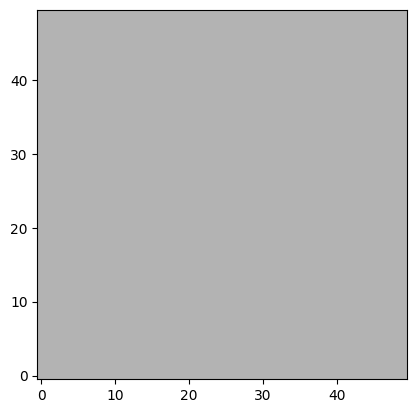

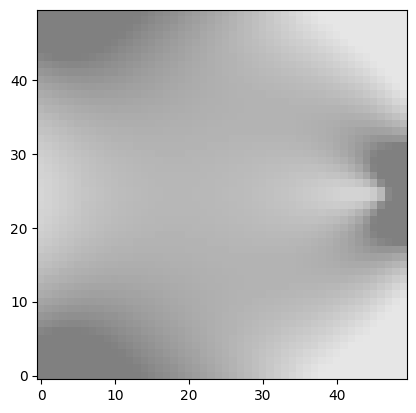

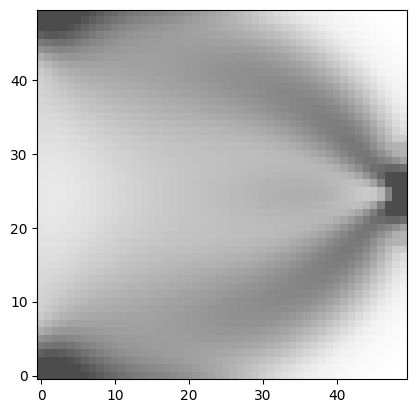

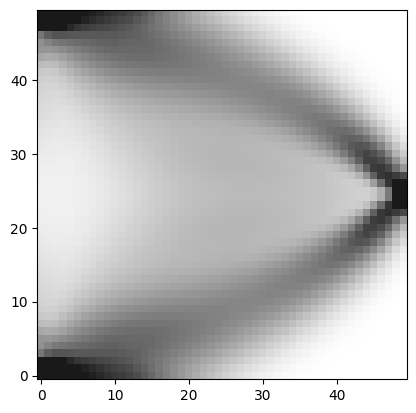

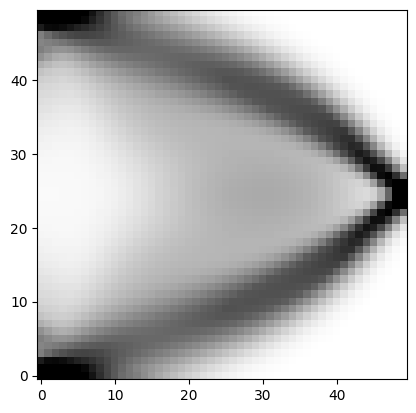

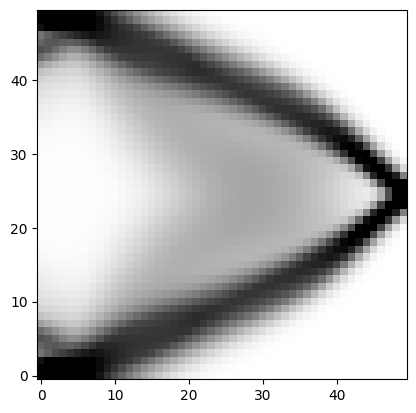

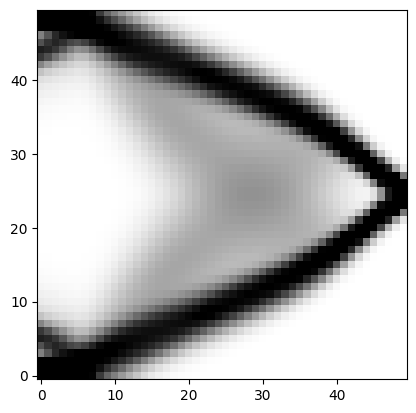

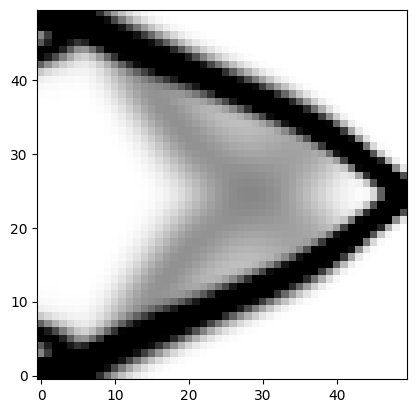

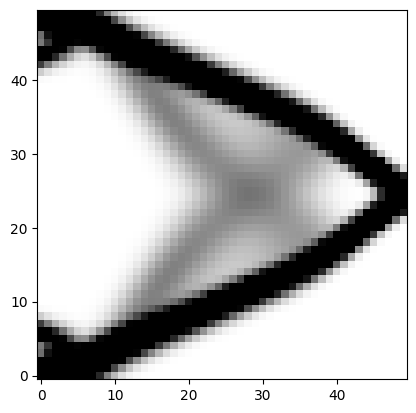

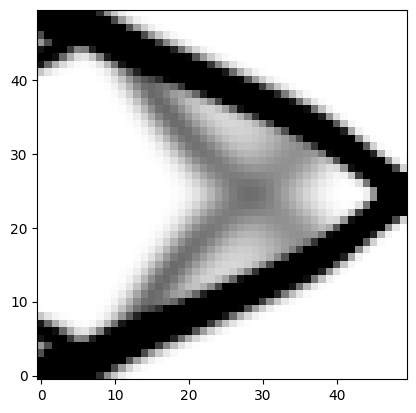

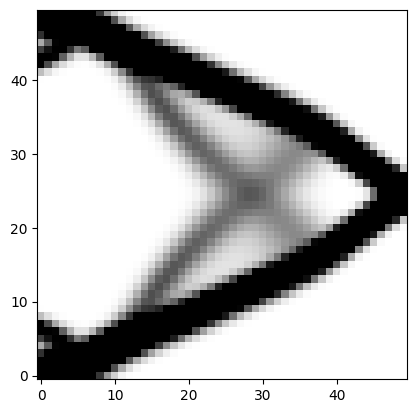

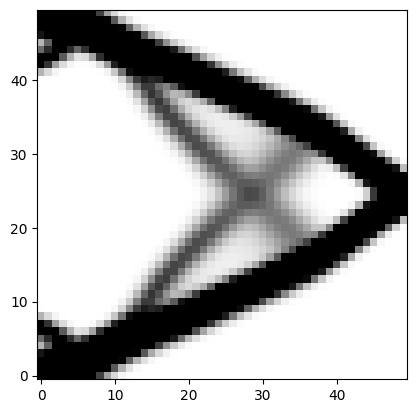

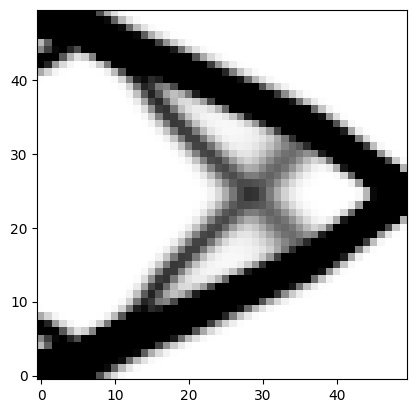

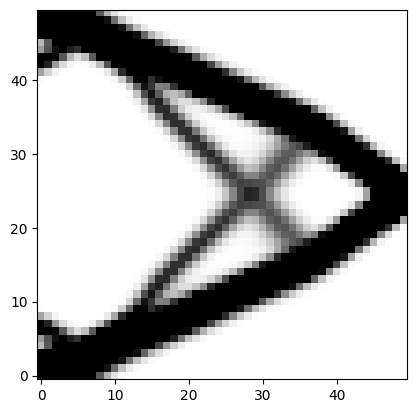

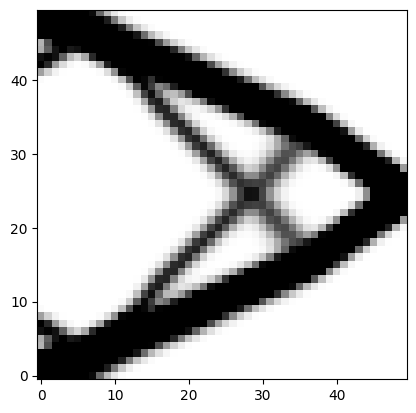

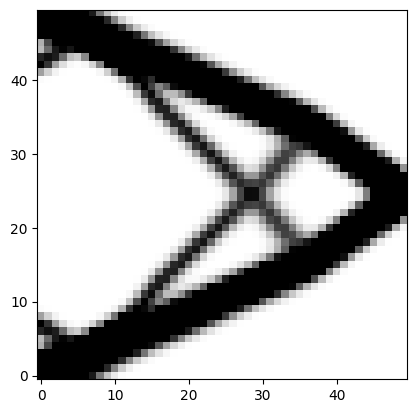

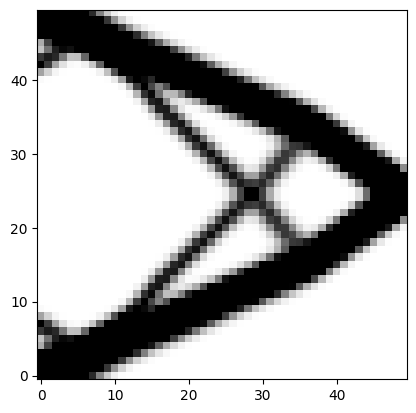

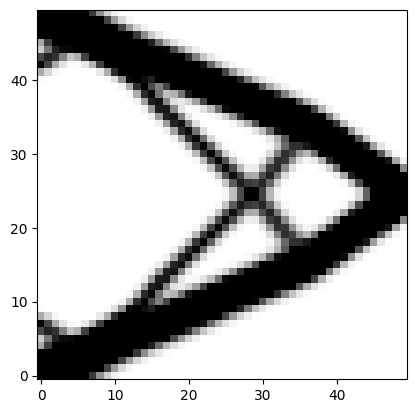

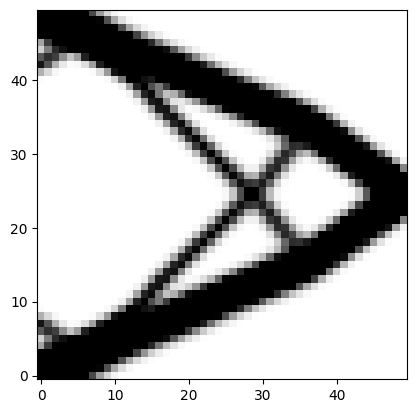

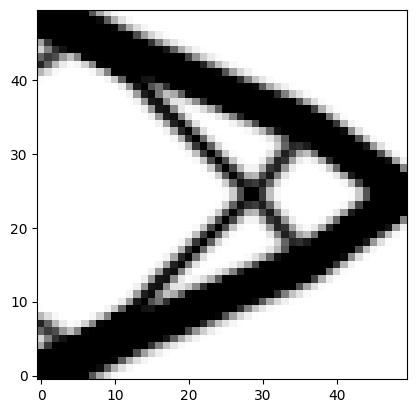

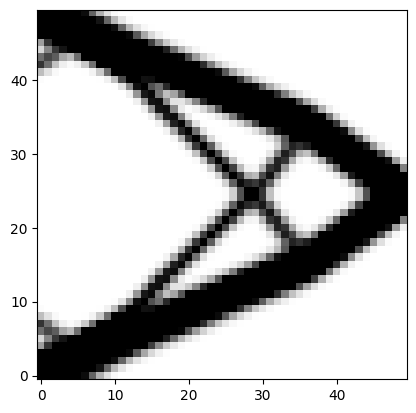

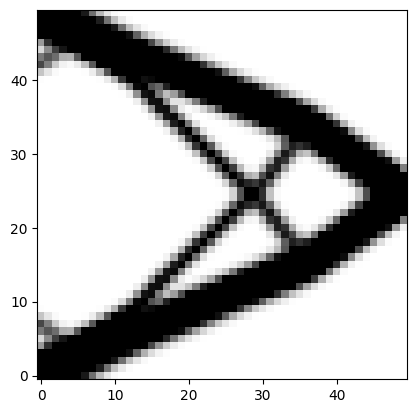

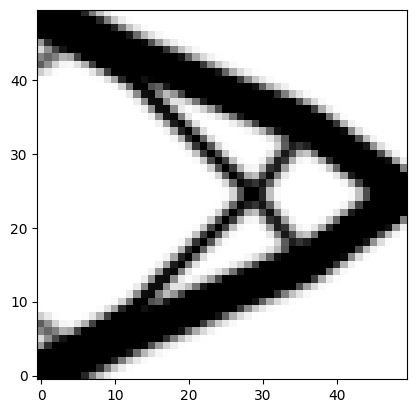

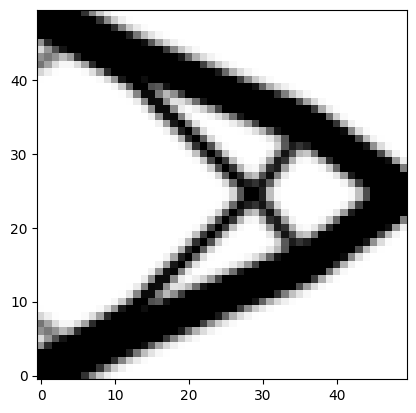

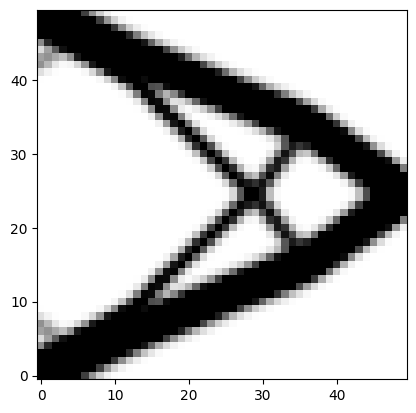

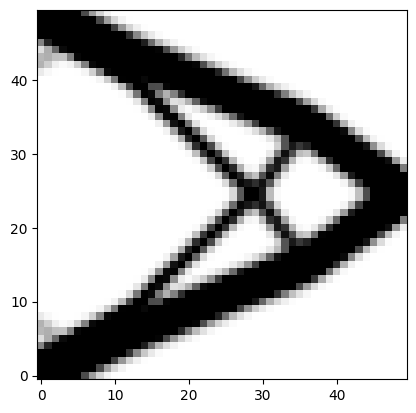

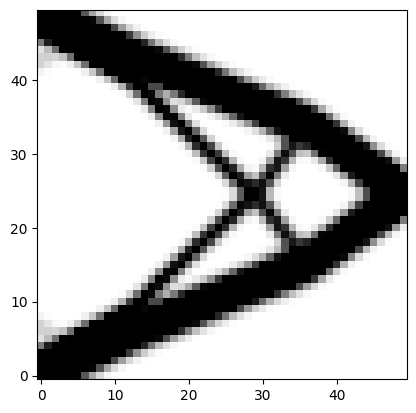

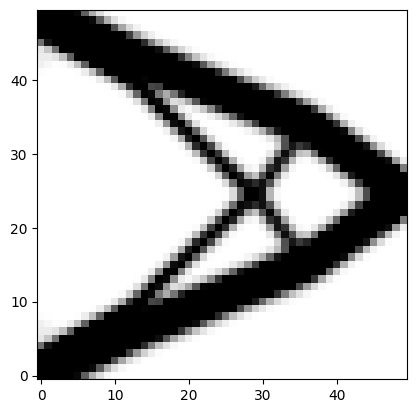

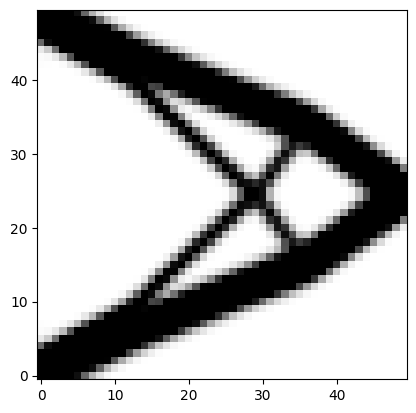

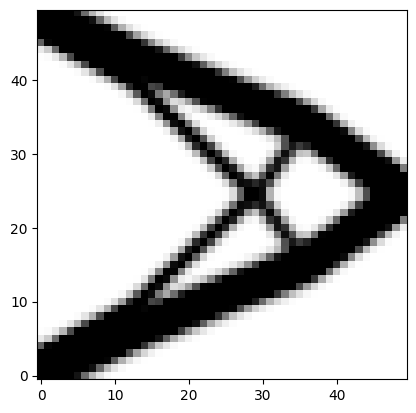

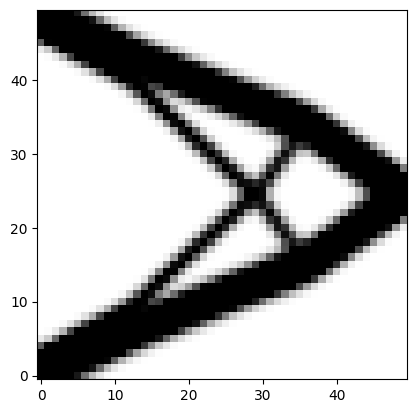

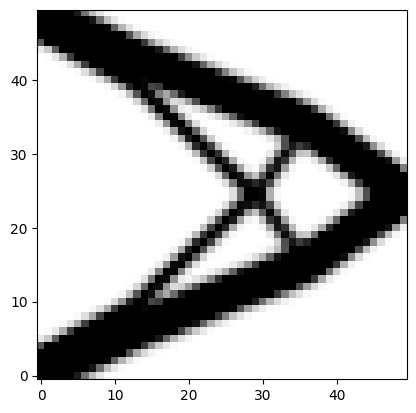

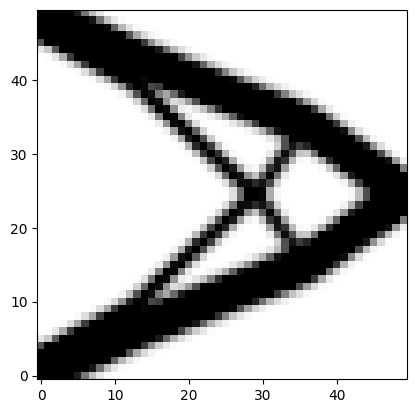

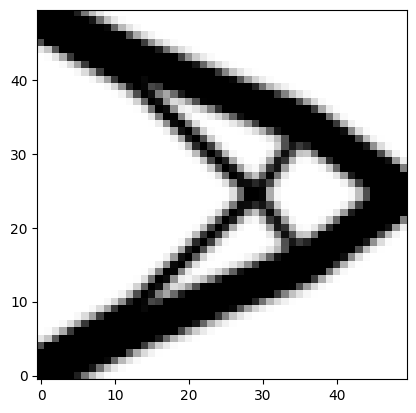

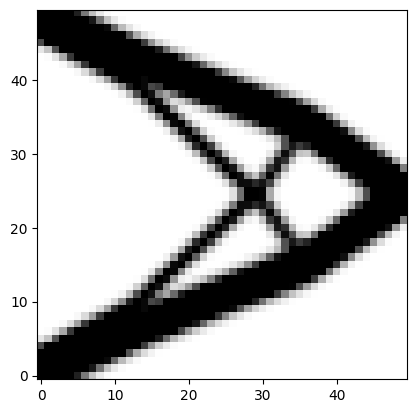

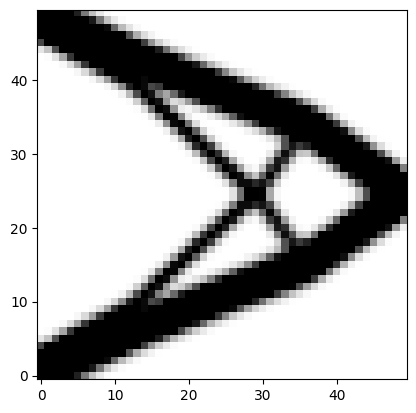

In [ ]:
# Plot the density function
for x in xList:
    fig,ax = plt.subplots()
    ax.imshow(-x.reshape((p['ny'],p['nx'])),origin='lower', cmap='gray', interpolation='none',norm=colors.Normalize(vmin=-1,vmax=0))
plt.close()